In [34]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt


In [3]:

#using single family home prices historical dataset (zillow has a few other options as well to try including w/ condos, Xbedrooms, etc.)
sfh_prices = pd.read_csv("/Users/afrazier/Documents/personal/real_estate/data/single_family_historical.csv")
print(sfh_prices.index.size)


30468


In [4]:
#pre-processing, filter out zipcodes without significant populations
twenty_ten_census_zip_populations = pd.read_csv("data/population_by_zip_2010.csv")
zip_populations = twenty_ten_census_zip_populations.groupby('zipcode')['population'].sum().reset_index()
prices_with_pops = sfh_prices.merge(zip_populations, left_on="RegionName", right_on="zipcode")
print(prices_with_pops.index.size)
#filter to zips with atleast 5K people living there
min_population = 5000
prices_with_pops = prices_with_pops[prices_with_pops.population>min_population]
print(prices_with_pops.index.size)
sfh_prices = prices_with_pops

29906
19329


In [5]:
#melt the date,price into multiple rows instead of one wide table
date_cols = [x for x in sfh_prices.columns if sfh_prices[x].dtype=='float64']
melted_prices = pd.melt(sfh_prices, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName','State', 'City', 'Metro', 'CountyName'], value_vars=date_cols)
melted_prices = melted_prices.rename(columns = {"variable": "date", "value": "price"})
melted_prices.date = pd.to_datetime(melted_prices.date)


In [20]:
# remove years/zips with null prices -> 693977/5044869 (~14%) null prices 
melted_prices = melted_prices[~(melted_prices.price.isnull())]

In [53]:
#add in the year distnace from the last date so we can perform regression on the price
max_date = melted_prices.date.max()
melted_prices['months_difference'] = (melted_prices.date-max_date)/(np.timedelta64(1, 'Y'))
zipcode_slopes = melted_prices.sort_values(["RegionName", "date"]).groupby("RegionName").apply(
            lambda x: linregress(x.months_difference, x['price'])[0]).round()
zipcode_slopes.name = "annual_price_slope"
zipcode_stds = melted_prices.groupby("RegionName")['price'].std().round()
zipcode_stds.name = "annual_price_std_deviation"
zipcode_datapoints = melted_prices.groupby("RegionName")['price'].size()
zipcode_datapoints.name = "total_data_points"

<ipython-input-53-bff1b5639cec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melted_prices['months_difference'] = (melted_prices.date-max_date)/(np.timedelta64(1, 'Y'))


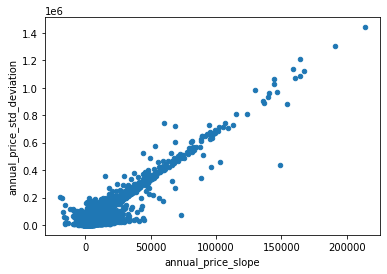

In [66]:
ten_year_slope_and_stds = pd.concat([zipcode_slopes, zipcode_stds, zipcode_datapoints], axis=1)
#lets filter to zipcodes with atleast 1.5 years of data?
ten_year_slope_and_stds =  ten_year_slope_and_stds[ten_year_slope_and_stds.total_data_points>=18]

ten_year_slope_and_stds.plot.scatter(x="annual_price_slope", y="annual_price_std_deviation")

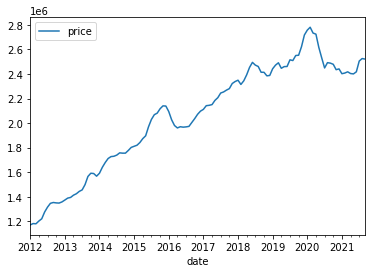

In [71]:
#one dot with very high slope but significantly lower STD? 
ten_year_slope_and_stds[ten_year_slope_and_stds.annual_price_slope>130000].sort_values("annual_price_std_deviation")
# 94129 -> San Francisco?!

melted_prices[melted_prices.RegionName==94129][['date', 'price']].set_index("date").plot()
#SFH prices in SF are now at aroudn $2.6M, which seems like a lot but might be a steal given their previous trendline


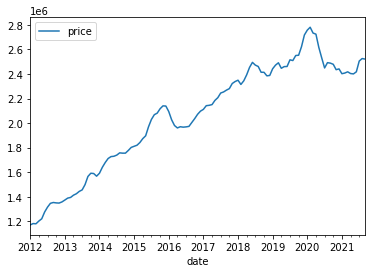